## final project submission

Please fill out:
* Student name: Claire Sarraille
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL: https://clairesarraille.github.io/2021/08/08/kings_county_housing.html


In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
from patsy import dmatrices

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

## crisp-dm:

- Business Understanding
    - Who will be  using the model
    - How will the model be used
    - How will using the model help our business
    - clarify requirements
    - What problems are in and out of scope

- Understand Data
    - What is target
    - What are predictors
    - Distribution of Data
    - How many observations - and is this a small, medium or large collection?
    - What is the quality? - What errors could be in the data, or inaccuracy?

- Data Preparation - Prepping to model
    - Missing values
    - Type conversions
    - Remove multicollinearity (correlated predictors)
    - Normalize numeric data
    - Convert categorical data to numeric via one-hot encoding

- Modeling:
    - Tune models to get the highest performance possible on our task
    - Considerations:
        - What kind of task? Classification task? Regression task?
        - Which models will we use
        - Will we use regularization?
        - How will we validate our model?
        - Loss functions?
        - What is the performance threshold for success?

- Evaluation:
    - Does the model solve business problem outlined in step 1?
    - At this point, we may want to start over at the business understanding step, now that we have a deeper understanding
    - Things we may learn at this stage:
        - Need different data
        - Need more data
        - Should be going in a different direction
        - Should use classificaion rather than regression, or vice versa
        - Use different approach

- Deployment:
    - Move the model into production
    - Set up ETL - how much of preprocessing and cleaning can be automated?


# BUSINESS UNDERSTANDING
- Who will be  using the model
    - The real estate agency I work for
- How will the model be used
    - Help a sub-set of home owners sell homes, by suggesting the most lucrative home renovations by their impact on home selling price.
- How will using the model help our business
    - We can give good advice to homeowners about how home renovations might increase the estimate value of their homes, and by how much
    - This will increase the amount of sales, thus increasing both our's and the home owner's profits
- clarify requirements
    - Find the features that are highest correlated with a higher sell price. Find how many dollars each unit of each feature adds to price
    - Use these correlations to recommend home renovations, ranked by the most to least positive impact on price.
- What problems are in and out of scope
    - How do home renovations impact the sell price of a home.
    - How locational factors impact price: homeowners cannot re-locate homes and we are assuming they can't change view of waterfront 

## Business Questions:
- Useful to subset data into waterfront vs. non-waterfront models?
- Remove outliers so that we're looking at average homes?
    - Average home in America has about 4 bedrooms
- If we normalize all of our predictors so they are on the same scale (z-score normalization), how do we un-normalize these features to interpret how they impact price?

# UNDERSTAND DATA
- What is **target**
>'price'
- What are **predictors**
>'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'yr_built'
- Distribution of Data - See Distribution Section
- How many observations - and is this a small, medium or large collection?
    - 21,597 entries
    - According to Frank Harrell in his book Regression Modeling Strategies, you need at least 10-20 observations per predictor
    - We have many, many more observations than 20 * (6 - num covariates) = 120
    - Our dataset would be considered large
- What is the quality? - What errors could be in the data, or inaccuracy? - See Data Quality Section

## Read in Data

In [172]:
df = pd.read_csv('data/kc_house_data.csv')

## Remove Features - recommended by Flatiron to remove
- date (no explanatory value)
- view ( has been viewed, this wouldn't help us predict prices) 
- Note: **sqft_above + sqft_basement = sqft_living**, according to meta-data:
    - sqft_above (repeating sqft_living)
    - sqft_basement (repeating sqft_living)
- yr_renovated (repeating yr_built)
- Not helpful to have geographic features becuase renovation can't inclue re-locating house (ostensibly)
    - zipcode
    - lat
    - long
- sqft_living15 (repeating sqft_living)
- sqft_lot15 (repeating sqft_lot)

In [173]:
# Why reduce features?
# I narrowed my list of features to avoid over-fit of the training dataset
# Reducing redundancy in features increases the accuracy of the model

df = df.drop(['date','view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'], axis=1)

In [174]:
# Note:sqft_living includes a finished basement, if present
# Grade is the construction quality of improvements, according to a King County grading system
# Condition is overall condition of house
df.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'condition', 'grade', 'yr_built'],
      dtype='object')

## Data Quality

- There could be outliers - such as hundreds of bathrooms - which doesn't make sense with square footage
- Year could be in the future
- price could be a negative number
- datatype could be wrong - such as string for number of bedrooms

### Waterfront Missing Values 
I filled in NaN values for 'waterfront' with 0. Now, 'waterfront' has a 1 value if there is a view, and 0 value if there is not.
I also cast this column as an integer type since there are no other options besides the integers 1 and 0.

In [175]:
# The only field that I retained containing NaN values is waterfront:
df.isnull().sum()

id                0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront     2376
condition         0
grade             0
yr_built          0
dtype: int64

In [176]:
# Note: waterfront is our only categorical value.
# We don't need to use dummy coding or any other coding system because it's already dichotomous (1 or 0) 
df['waterfront'] = df['waterfront'].fillna(0)
df['waterfront'] = df["waterfront"].astype(int)
df['waterfront'].unique()

array([0, 1])

## Cast Features -- at a Different Scale for Visualization 

In [177]:
# Create lot size in acres:
df['acres_lot'] = df['sqft_lot'] / 43560 

In [178]:
# Create price column in millions:
df['price_millions'] = df['price'] / 1000000

In [179]:
df[['price_millions','price', 'acres_lot']]

,price_millions,price,acres_lot
0,0.221900,221900.0,0.129706
1,0.538000,538000.0,0.166253
2,0.180000,180000.0,0.229568
3,0.604000,604000.0,0.114784
4,0.510000,510000.0,0.185491
...,...,...,...
21592,0.360000,360000.0,0.025964
21593,0.400000,400000.0,0.133448
21594,0.402101,402101.0,0.030992
21595,0.400000,400000.0,0.054821


In [180]:
print(f"The max price is {df['price_millions'].max()} million, min price is {df['price'].min()}")

The max price is 7.7 million, min price is 78000.0


## DISTRIBUTIONS

### Clarify Grade and Condition Columns

#### King County's Grading System for Buildings:
##### Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

1. Falls short of minimum building standards. Normally cabin or inferior structure.

2. Falls short of minimum building standards. Normally cabin or inferior structure.

3. Falls short of minimum building standards. Normally cabin or inferior structure.

4. Generally older, low quality construction. Does not meet code.

5. Low construction costs and workmanship. Small, simple design.

6. Lowest grade currently meeting building code. Low quality materials and simple designs.

7. Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8. Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9. Better architectural design with extra interior and exterior design and quality.

10. Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11. Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12. Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13. Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

#### King County's Condition Scale: 
##### Relative to age and grade. Coded 1-5.

1. Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

2. Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

3. Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

4. Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

5. Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.

### Describe Data - Descriptive Statistics

In [181]:
format_dict = {'bedrooms': '{:.2f}', 'bathrooms': '{:.2f}', 'floors': '{:.2f}', 'sqft_living': '{:20,.2f}', 'sqft_lot': '{:20,.2f}',
               'acres_lot': '{:.2f}',  'price': '{:20,.0f}', 'yr_built': '{:.0f}', 'condition': '{:.2f}', 'grade': '{:.2f}', 'waterfront': '{:.5f}'}
df[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'acres_lot', 'floors',
    'waterfront', 'condition', 'grade', 'yr_built']].describe().style.format(format_dict)

,price,bedrooms,bathrooms,sqft_living,acres_lot,floors,waterfront,condition,grade,yr_built
count,"21,597",21597.00,21597.00,"21,597.00",21597.00,21597.00,21597.00000,21597.00,21597.00,21597
mean,"540,297",3.37,2.12,"2,080.32",0.35,1.49,0.00676,3.41,7.66,1971
std,"367,368",0.93,0.77,918.11,0.95,0.54,0.08194,0.65,1.17,29
min,"78,000",1.00,0.50,370.00,0.01,1.00,0.00000,1.00,3.00,1900
25%,"322,000",3.00,1.75,"1,430.00",0.12,1.00,0.00000,3.00,7.00,1951
50%,"450,000",3.00,2.25,"1,910.00",0.17,1.50,0.00000,3.00,7.00,1975
75%,"645,000",4.00,2.50,"2,550.00",0.25,2.00,0.00000,4.00,8.00,1997
max,"7,700,000",33.00,8.00,"13,540.00",37.91,3.50,1.00000,5.00,13.00,2015


#### Interpret .describe() 
- There are no negative values for any of the columns
- The year range makes sense: homes were built between 1900 and 2015
- sqft_living average is around 2,000, which is close to the US average
- The average lot size is 15,099 square feet, or .35 acres
- The lot size mean is skewed by our outlier home, which stands on a 37.91 acre lot.
- The median sqft_lot size is 7,618 or .17 acres, which is much closer to the national average of 0.188 of an acre.
- Condition and Grade: The mean, max, and min all line-up with the scale of the system, described above.
    - Mean Grade is 7.66, so between a 7 and 8: 
        - 7. Average grade of construction and design. Commonly seen in plats and older sub-divisions.
        - 8. Just above average in construction and design. Usually better materials in both the exterior and interior finish work.
    - Mean Condition is 3.41, closest to a 3: 
        - 3. Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

### Price Frequency Histogram

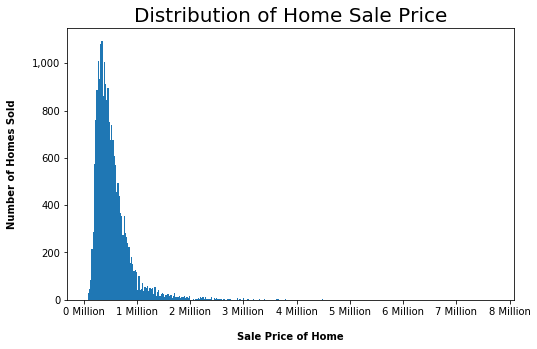

In [182]:
ax = df.hist(column='price_millions',
             bins='auto',
             grid=False,
             figsize=(8,5))

ax = ax[0]
for x in ax:

    x.set_title("Distribution of Home Sale Price", size=20)

    # Set x-axis label
    x.set_xlabel("Sale Price of Home", labelpad=15, weight='bold', size=10)
    x.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}' + ' Million'))

    # Set y-axis label
    x.set_ylabel("Number of Homes Sold", labelpad=15, weight='bold', size=10)
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))


### Narrow dataset for modeling 

In [183]:
# Remember all columns in df are: 
df.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'condition', 'grade', 'yr_built', 'acres_lot',
       'price_millions'],
      dtype='object')

In [184]:
# Select a subset of columns to create matrix:
df_model = df.drop(['acres_lot','id'], axis=1)

In [185]:
df_model.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'yr_built', 'price_millions'],
      dtype='object')

### Scatter Matrix Distribution

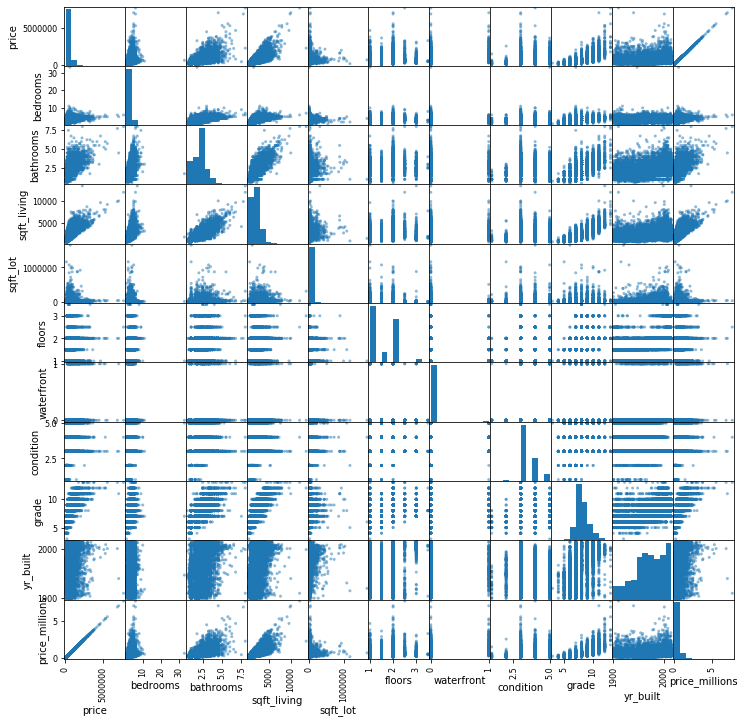

In [186]:
pd.plotting.scatter_matrix(df_model, figsize=(12,12))
plt.show()

### Notes on Scatter Matrix Dist:
- A lot of our data correlated with yr_built does not show a trend.
- That's why we need to normalize our data, because "year" is on such a different scale than say, bedrooms.

### Price Density Histogram

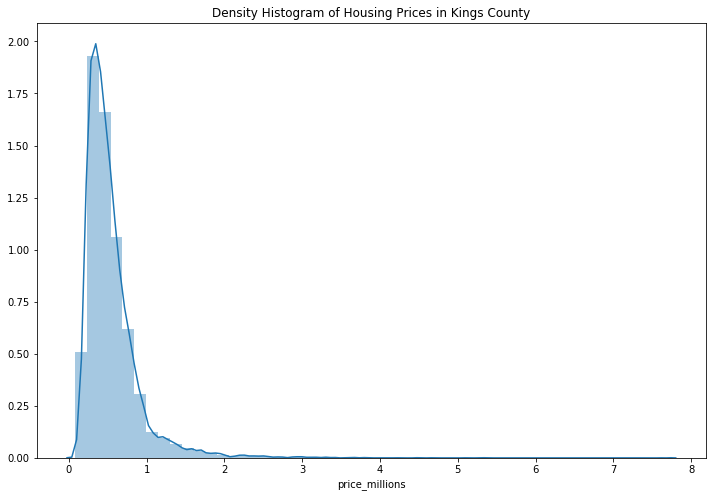

In [187]:
# From this we can see that generally, most houses are priced below one million dollars
# We can also see there is considerable right-skew in the price of the homes in our dataset
plt.figure(figsize = (12,8))
sns.distplot(df_model.price_millions,kde=True)
plt.title('Density Histogram of Housing Prices in Kings County')
plt.show()

### Waterfront-Price Density Histogram
Let's show another type of distribution now that we have "waterfront" column cleaned up

In [188]:
# Density histogram of house price - waterfront vs. non-waterfront:
water_df =  df_model.loc[df['waterfront'] == 1]
no_water_df =  df_model.loc[df['waterfront'] == 0]

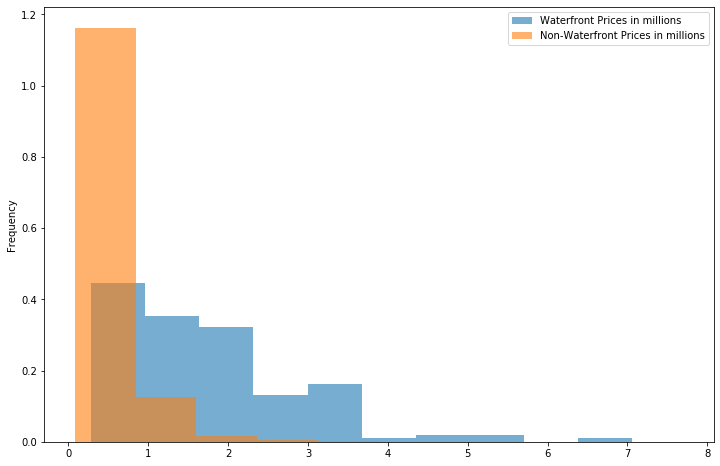

In [189]:
# Plot histograms (with densities on the y-axis) for waterfront and non-waterfront house prices:
plt.figure(figsize = (12,8))
binsize = 10
water_df.price_millions.plot.hist(bins = binsize, density = True,  alpha = 0.6, label ="Waterfront Prices in millions");
no_water_df.price_millions.plot.hist(bins = binsize, density = True, alpha = 0.6, label = 'Non-Waterfront Prices in millions');
plt.legend()
plt.show()


### Interpret Waterfront-Price Density Histogram
- Waterfront properties tend to have higher selling prices than non-waterfront properties
- Waterfront properties have a higher spread than non-watefront properties - that's why the waterfront peak is smaller than the non-waterfront peak
- Neither price distributions are normally distributed
- Waterfront and non-waterfront properties overlap in price from about .3-.7 million

### Waterfront-Price KDE

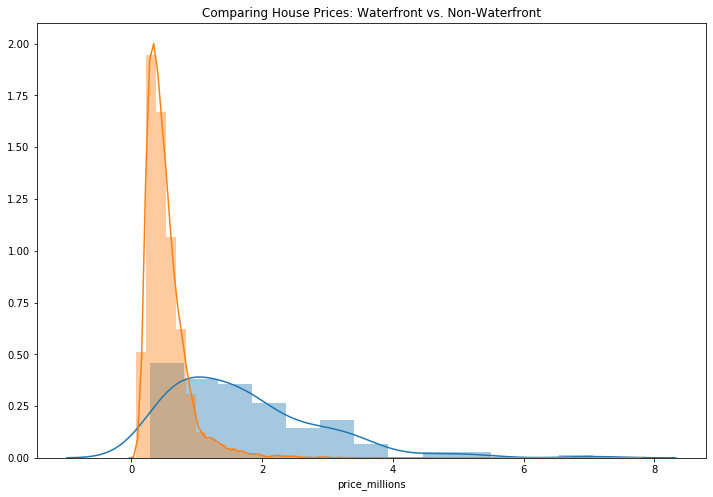

In [190]:
# Ok. Now let's draw a smooth curve, given the above data, using KDE (kernal density estimation)
# The smooth line in the visualization below is an estimate of the distributions of waterfront and non-waterfront house prices
# The parameter bandwidth rules the smoothness of the underlying distribution

# The problem with a Probability Density Function plot, is that all "point probabilities" are 0
# We must calculate the area under the curve for an interval to get the actual probability for an interval of house prices.
# Thus, it's not intuitive or easy to "read" the y-axis to get probabilities for continuous variables using a PDF like below.

plt.figure(figsize = (12,8))
sns.distplot(water_df.price_millions,kde=True)
sns.distplot(no_water_df.price_millions,kde=True)
plt.title('Comparing House Prices: Waterfront vs. Non-Waterfront')
plt.show()




### Probability of Waterfront Price 2-4 mill
For example, if we wanted to know the probability that a waterfront house price is between 2 and 4 million dollars (inclusive), we would use the following formula to take the integral of this range (AKA area under the curve)
$$\large P(2 \leq X \leq 4) = \int_{2}^{4} f_x(x) dx \geq 0 $$


# DATA PREPARATION
- Prepping to model
- Missing values
- Convert categorical data to numeric via one-hot encoding (we didn't need to do this because everything is ordinal and non-text)
- Type conversions (this was done in the previous section - price to millions and sqft to acres)
- Remove multicollinearity (correlated predictors)
- Normalize numeric data


## Normalize Numeric Data
- The z-score normalization method is the most common
- If standard deviation is a yardstick, then a z-score is the measurement expressed in terms of that yardstick
- For example, if we find the z-score for a given x-value's distance from x-bar  divided by the standard deviation...
- We have convereted the distance of x from x-bar to "standard deviation units"
- If s = 30, then we want to see how many s's (quantities of 30) that x is from x-bar
- Basically, a z-score expresses each value of x as a standard unit away from the mean (x-bar)

In [191]:
# make copy of df_model for normalization purposes: 
df_norm = df_model.copy()

# Apply z-score normalization:
def z_score_norm(my_column):
    return (my_column - my_column.mean())/my_column.std()

for predictor in ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition','grade','yr_built']:
    df_norm[predictor] = z_score_norm(df_norm[predictor])
    
# print normalized data: 
print(df_norm)

          price  bedrooms  bathrooms  sqft_living  sqft_lot    floors  \
0      221900.0 -0.402894  -1.451039    -0.980629 -0.228177 -0.915531   
1      538000.0 -0.402894   0.174482     0.533357 -0.189735  0.937409   
2      180000.0 -1.482459  -1.451039    -1.427201 -0.123137 -0.915531   
3      604000.0  0.676671   1.149794    -0.131054 -0.243873 -0.915531   
4      510000.0 -0.402894  -0.150622    -0.436030 -0.169499 -0.915531   
...         ...       ...        ...          ...       ...       ...   
21592  360000.0 -0.402894   0.499586    -0.599410 -0.337298  2.790349   
21593  400000.0  0.676671   0.499586     0.250165 -0.224241  0.937409   
21594  402101.0 -1.482459  -1.776143    -1.154901 -0.332010  0.937409   
21595  400000.0 -0.402894   0.499586    -0.523166 -0.306945  0.937409   
21596  325000.0 -1.482459  -1.776143    -1.154901 -0.338626  0.937409   

       waterfront  condition     grade  yr_built  price_millions  
0       -0.082498  -0.629972 -0.560787 -0.544665        

## Explore Multicollinearity
- This a phenemonen where two variables we are using as predictors are correlated with each other
- This violates one of the assumptions of performing linear regression - that all independent variables are independent from one another
- If we left all features in the model without addressing multicollinearity, it would become very hard for the model to estimate the relationship between independent variables and the dependent variable, because rather than change independently, the features would change in pairs or groups.

In [192]:
correlations = df_norm.drop(['price'],axis = 1).corr()

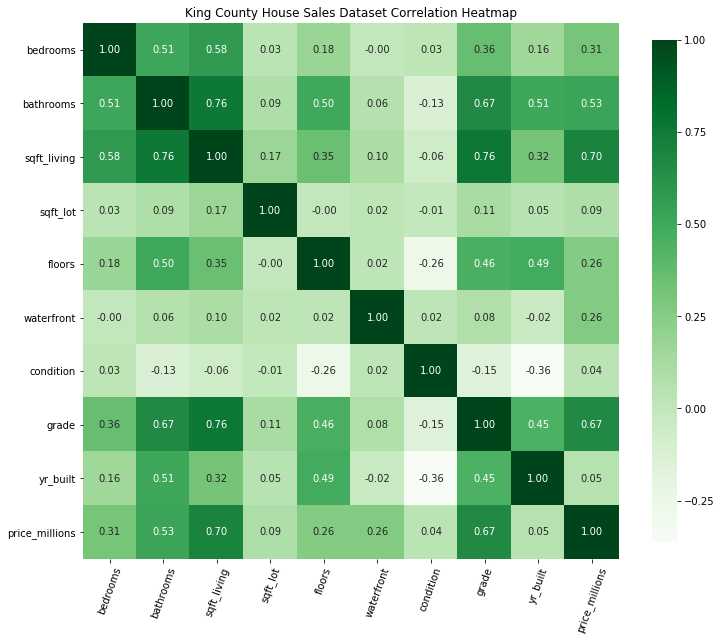

In [193]:
plt.figure(figsize=(12,12)) # Set size of figure
# Use df.corr() as your matrix for the heatmap
# I set the color scheme to green using cmap
# annot= True adds the float value on each square
# fmt='.1f' sets the number of decimal places for each float number. If you want 1.00, for example, use fmt='.2f'
# cbar_kws={"shrink": .77}  - this argument shrinks the side color bar to .77 of its original size
# square=True - this argument makes the figure square
ax = sns.heatmap(correlations, cmap = "Greens", annot=True, fmt='.2f', cbar_kws={"shrink": .77}, square=True)
# Sets the title
ax.set(title='King County House Sales Dataset Correlation Heatmap')
# Get the y-axis limit values for the size of the figure:
bottom, top = ax.get_ylim()
# Add .5 to the bottom and top of the y-axis limits to fix an error where the top and bottom squares are cut off
# This is an error for the versions of Seaborne and Matplotlib I'm using
ax = ax.set_ylim(bottom + 0.5, top - 0.5)
# Rotate the bottom labels by 30 degrees (100-70)
plt.xticks(rotation=70)
plt.show()


In [194]:
correlations['price_millions'].sort_values(ascending=False)

price_millions    1.000000
sqft_living       0.701917
grade             0.667951
bathrooms         0.525906
bedrooms          0.308787
waterfront        0.264306
floors            0.256804
sqft_lot          0.089876
yr_built          0.053953
condition         0.036056
Name: price_millions, dtype: float64

In [195]:
correlations["sqft_living"].sort_values(ascending=False)

sqft_living       1.000000
grade             0.762779
bathrooms         0.755758
price_millions    0.701917
bedrooms          0.578212
floors            0.353953
yr_built          0.318152
sqft_lot          0.173453
waterfront        0.104637
condition        -0.059445
Name: sqft_living, dtype: float64

### Correlations Interpretation 
- Features highly correlated with price are sqft_living, grade, and bathrooms
- Features highly correlated with sqft_living are grade, bathrooms, price_millions, and bedrooms

## Address Multicollinearity

In [197]:
df_norm.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'yr_built', 'price_millions'],
      dtype='object')

In [198]:
df_norm.shape

(21597, 11)

In [199]:
house_pred = df_norm.drop(['price','price_millions'], axis=1)

In [200]:
# We want to write a simple loop to use statsmodel's variance_inflation_factort method on each array (row) of our dataframe, for each column 
# That's why we use X.shape[1] as the range in the loop below, since the second term in the output of the .shape method is the number of columns
X = sm.add_constant(df_norm.drop(['price','price_millions'], axis=1))
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

const          1.000000
bedrooms       1.628887
bathrooms      3.186926
sqft_living    4.152240
sqft_lot       1.047462
floors         1.573844
waterfront     1.021879
condition      1.182857
grade          2.888261
yr_built       1.734538
dtype: float64

### sqft_living has a moderately high VIF value, so we can try removing to see if it helps with our model

# MODELING
- Tune models to get the highest performance possible on our task
  - Considerations:
    - What kind of task? Classification task? Regression task?
    - Which models will we use
    - Will be use regularization?
    - How will we validate our model?
    - Loss functions?
    - What is the performance threshold for success?


# Linear Regression - Ordinary Least Squares

In [201]:
df_norm.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'yr_built', 'price_millions'],
      dtype='object')

## All Cols - statsmodel

In [202]:
house_pred = df_norm.drop(['price','price_millions'], axis=1)
house_target = df_norm['price_millions']

In [203]:
# Add constant (AKA y-intercept):
# The constant is set to 1 as default - with means that our constant coefficient will be equal to 1*Beta(0)
# For our other variables (other Betas) will be multiplied by a particular coefficient to predict price
predictors = sm.add_constant(house_pred)
predictors.head()

,const,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
0,1.0,-0.402894,-1.451039,-0.980629,-0.228177,-0.915531,-0.082498,-0.629972,-0.560787,-0.544665
1,1.0,-0.402894,0.174482,0.533357,-0.189735,0.937409,-0.082498,-0.629972,-0.560787,-0.680835
2,1.0,-1.482459,-1.451039,-1.427201,-0.123137,-0.915531,-0.082498,-0.629972,-1.413157,-1.293596
3,1.0,0.676671,1.149794,-0.131054,-0.243873,-0.915531,-0.082498,2.444371,-0.560787,-0.204243
4,1.0,-0.402894,-0.150622,-0.436030,-0.169499,-0.915531,-0.082498,-0.629972,0.291583,0.544688


In [204]:
# The order of the parameters is: endogenous response variable(dependent variable), exogenous variables(independent variables)
model = sm.OLS(house_target, predictors).fit()

In [205]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price_millions   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     4370.
Date:                Sun, 08 Aug 2021   Prob (F-statistic):               0.00
Time:                        20:47:23   Log-Likelihood:                 2185.7
No. Observations:               21597   AIC:                            -4351.
Df Residuals:                   21587   BIC:                            -4272.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5403      0.001    363.009      0.000       0.537       0.543
bedrooms       -0.0394      0.002    -20.757      0.000      -0.043      -0.036
bathrooms       0.0390      0.003     14.695      0.000       0.034       0.044
sqft_living     0.1627      0.003     53.646      0.000       0.157       0.169
sqft_lot       -0.0101      0.002     -6.605      0.000      -0.013      -0.007
floors          0.0113      0.002      6.069      0.000       0.008       0.015
waterfront      0.0619      0.002     41.124      0.000       0.059       0.065
condition       0.0123      0.002      7.620      0.000       0.009       0.016
grade           0.1526      0.003     60.319      0.000       0.148       0.158
yr_built       -0.1130      0.002    -57.635      0.000      -0.117      -0.109
==============================================================================
Omnibus:                    15869.187   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1011405.789
Skew:                           2.942   Prob(JB):                         0.00
Kurtosis:                      36.005   Cond. No.                         4.76
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## All Cols - sklearn

In [206]:
# Split normalized data into target/dependent variable and predictors/features/explanatory variables/independent variables
X = df_norm.drop(['price','price_millions'], axis=1) # independent variables
y = df_norm['price_millions'] # dependent variable

In [207]:
# Divide into test and train data
# Train data is for us to estimate our OLS model
# Test data is to parameterize our model, using that model to predict y values (price)
# If test_size = .3, that means 30% of our data is set aside for the testing data
# And 70% of that data for training

# The parameter "random_state" ensures that if there is skew in our data, our 30-70 split is randomly taking from these groups
# So we have good proportions of randomly selected data and our 30-70 split has good representation 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=4)

In [208]:
# Linear Regressor - Ordinary Least Squares regression-type estimate:
lr = LinearRegression()

In [209]:
# Train model based on train dataset:
# Regressing the X's onto the y:
# We're getting a fit here, having used 70% of the data
lr.fit(X_train, y_train)
coef_list = list(lr.coef_)
name_list = list(X_train.columns)

In [210]:
# Model prediction based on train dataset:
predict_y_train = lr.predict(X_train)

In [211]:
# Training Data R-Squared Value:
print('The R squared value is: ' + str(metrics.r2_score(y_train, predict_y_train)))

The R squared value is: 0.6418071120403939


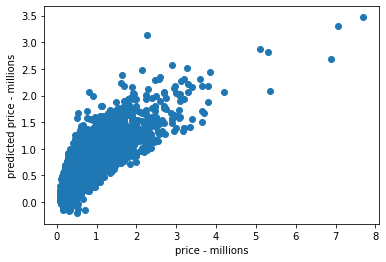

In [212]:
# Actual Prices vs. Predicted Prices:
plt.scatter(y_train, predict_y_train)
plt.xlabel('price - millions')
plt.ylabel('predicted price - millions')
plt.show()

### Interpret price vs. predicted price scatterplot:
- The distribution isn't a straight line, and from that we know that there is something non-linear going on in the relationships we've modeled. 
- We don't have a good linear relationship between price and our predictors

Text(0, 0.5, 'residuals')

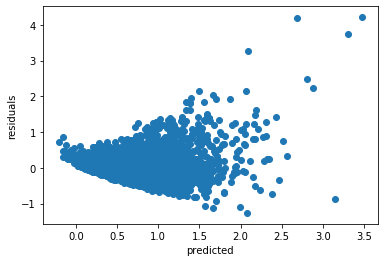

In [213]:
# Predicted Price vs. Residuals
# Inspect the amount of error we got from our OLS Linear Regression:
# The residual is the amount of error in the estimation (difference between predicted and actual y values)

plt.scatter(predict_y_train, y_train - predict_y_train)
plt.xlabel('predicted')
plt.ylabel('residuals')

Text(0, 0.5, 'frequency')

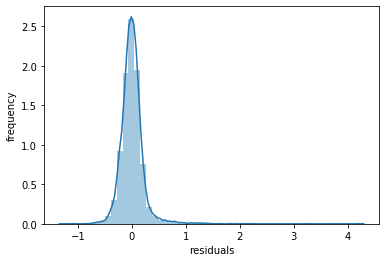

In [214]:
# Check Distribution of Errors:
# We can see from this that there's some right-skew to the distribution of error
sns.distplot(y_train - predict_y_train)
plt.xlabel('residuals')
plt.ylabel('frequency')

In [215]:
# Finally, we take the 30% of that data we set aside for testing, and examine the error for that:
predict_y_test = lr.predict(X_test)
print('The R squared value is: ' + str(metrics.r2_score(y_test, predict_y_test)))

The R squared value is: 0.6530001064251156


- So looks like in-sample, out-of-sample is not as robust as we might want, 
- since our R-squared value is less using test data than when using train data

## All Cols - Interpret
- Using all of our columns to predict price, and not subsetting the data at all:
- Our p-values are all 0.00, which is great.
- However, this model is violating necessary assumptions
    - The scatterplot of predicted price vs. price is clearly not a linear relationship
    - The plot of the residuals vs. the predicted price is a clear, trumpet shape, which is highly heteroscedastic.
    - What we are aiming for is linearity and homoscedasticity - a fairly even distribution of the residuals vs. predicted price

## Removing sqft_living due to Multicollinearity
- We will now attempt to remove the colum "sqft_living" because it showed moderate multicollinearity when we used the variance inflation factor method to measure multicollinearity.

In [216]:
house_pred = df_norm.drop(['price','price_millions','sqft_living'], axis=1)
house_target = df_norm['price_millions']
predictors = sm.add_constant(house_pred)
model = sm.OLS(house_target, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price_millions   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     4021.
Date:                Sun, 08 Aug 2021   Prob (F-statistic):               0.00
Time:                        20:47:54   Log-Likelihood:                 834.29
No. Observations:               21597   AIC:                            -1651.
Df Residuals:                   21588   BIC:                            -1579.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5403      0.002    340.998      0.000       0.537       0.543
bedrooms      -0.0019      0.002     -1.034      0.301      -0.006       0.002
bathrooms      0.1019      0.003     40.158      0.000       0.097       0.107
sqft_lot       0.0031      0.002      1.966      0.049     9.9e-06       0.006
floors         0.0033      0.002      1.654      0.098      -0.001       0.007
waterfront     0.0679      0.002     42.528      0.000       0.065       0.071
condition      0.0127      0.002      7.356      0.000       0.009       0.016
grade          0.2311      0.002    105.179      0.000       0.227       0.235
yr_built      -0.1306      0.002    -63.471      0.000      -0.135      -0.127
==============================================================================
Omnibus:                    18217.556   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1762716.589
Skew:                           3.533   Prob(JB):                         0.00
Kurtosis:                      46.691   Cond. No.                         3.20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpret Removal of sqft_living
- Removing sqft_lot actually lowered the R-squared value to .598 .646

### Modify Business Question:
- At this point I'm going to edit my business question. I would now like to find a segment of this data that conforms to the assumptions of linear regression 

## Waterfront Segment 
- We want to know if we get a good linear model if we segment the data into waterfront vs. non-waterfront homes

In [217]:
df_water =  df_norm.loc[df['waterfront'] == 1]
df_no_water =  df_norm.loc[df['waterfront'] == 0]

In [218]:
df_water.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'yr_built', 'price_millions'],
      dtype='object')

In [219]:
house_pred = df_water.drop(['price','price_millions'], axis=1)
house_target = df_water['price_millions']

In [220]:
predictors = sm.add_constant(house_pred)
model = sm.OLS(house_target, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price_millions   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     68.28
Date:                Sun, 08 Aug 2021   Prob (F-statistic):           4.74e-44
Time:                        20:48:15   Log-Likelihood:                -109.18
No. Observations:                 146   AIC:                             236.4
Df Residuals:                     137   BIC:                             263.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
bedrooms        0.0094      0.048      0.195      0.846      -0.086       0.105
bathrooms       0.0601      0.056      1.081      0.281      -0.050       0.170
sqft_living     0.4775      0.048      9.847      0.000       0.382       0.573
sqft_lot       -0.0506      0.041     -1.226      0.222      -0.132       0.031
floors         -0.0117      0.051     -0.229      0.819      -0.112       0.089
waterfront      0.0779      0.006     12.924      0.000       0.066       0.090
condition       0.0580      0.040      1.443      0.151      -0.021       0.137
grade           0.1040      0.054      1.915      0.058      -0.003       0.211
yr_built       -0.0737      0.064     -1.155      0.250      -0.200       0.052
==============================================================================
Omnibus:                        1.096   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.578   Jarque-Bera (JB):                0.878
Skew:                          -0.188   Prob(JB):                        0.645
Kurtosis:                       3.052   Cond. No.                         21.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [221]:
X = df_water.drop(['price','price_millions'], axis=1)
y = df_water['price_millions']

In [222]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=4)
lr = LinearRegression()
lr.fit(X_train, y_train)
predict_y_train = lr.predict(X_train)
print('The R squared value is: ' + str(metrics.r2_score(y_train, predict_y_train)))

The R squared value is: 0.8213563897907034


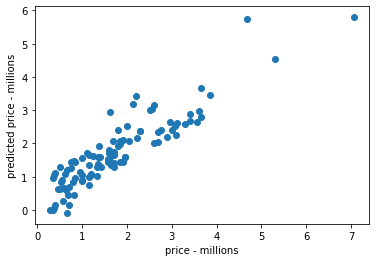

In [223]:
plt.scatter(y_train, predict_y_train)
plt.xlabel('price - millions')
plt.ylabel('predicted price - millions')
plt.show()

Text(0, 0.5, 'residuals')

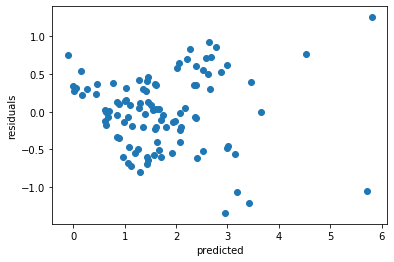

In [224]:
plt.scatter(predict_y_train, y_train - predict_y_train)
plt.xlabel('predicted')
plt.ylabel('residuals')

## Waterfront Interpret
- We have pretty good linearity, judging from the linear shape of our predicted price vs. price scatterplot
- The scatterplot of residuals vs. predicted price is less heteroscedastic than was the scatterplot for all data
- Howver, the p-values for our coefficients for the waterfront home segment are very high
- The only p-values that are good are sqft_living and grade

## Non-Waterfront Segment

In [225]:
house_pred = df_no_water.drop(['price','price_millions'], axis=1)
house_target = df_no_water['price_millions']

In [226]:
predictors = sm.add_constant(house_pred)
model = sm.OLS(house_target, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price_millions   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     4467.
Date:                Sun, 08 Aug 2021   Prob (F-statistic):               0.00
Time:                        20:48:33   Log-Likelihood:                 3047.0
No. Observations:               21451   AIC:                            -6076.
Df Residuals:                   21442   BIC:                            -6004.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
bedrooms       -0.0371      0.002    -20.253      0.000      -0.041      -0.034
bathrooms       0.0394      0.003     15.326      0.000       0.034       0.044
sqft_living     0.1514      0.003     51.332      0.000       0.146       0.157
sqft_lot       -0.0082      0.001     -5.606      0.000      -0.011      -0.005
floors          0.0127      0.002      7.081      0.000       0.009       0.016
waterfront     -6.4865      0.017   -373.229      0.000      -6.521      -6.452
condition       0.0125      0.002      8.007      0.000       0.009       0.016
grade           0.1550      0.002     63.352      0.000       0.150       0.160
yr_built       -0.1132      0.002    -59.968      0.000      -0.117      -0.110
==============================================================================
Omnibus:                    16110.243   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1073938.414
Skew:                           3.032   Prob(JB):                         0.00
Kurtosis:                      37.129   Cond. No.                         22.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [227]:
X = df_no_water.drop(['price','price_millions'], axis=1) # independent variables
y = df_no_water['price_millions'] # target variable

In [228]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=4)
lr = LinearRegression()
lr.fit(X_train, y_train)
predict_y_train = lr.predict(X_train)
print('The R squared value is: ' + str(metrics.r2_score(y_train, predict_y_train)))

The R squared value is: 0.6252639004561333


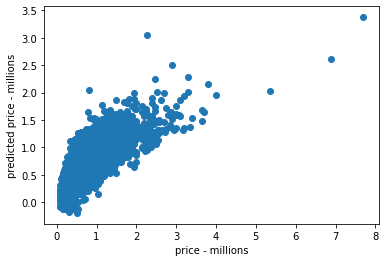

In [229]:
plt.scatter(y_train, predict_y_train)
plt.xlabel('price - millions')
plt.ylabel('predicted price - millions')
plt.show()

Text(0, 0.5, 'residuals')

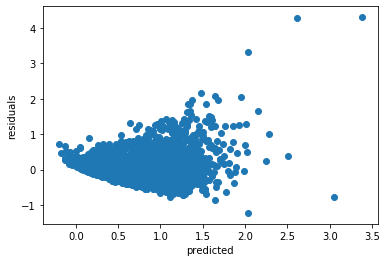

In [230]:
plt.scatter(predict_y_train, y_train - predict_y_train)
plt.xlabel('predicted')
plt.ylabel('residuals')

## Non-Waterfront Interpret
- When we segment the data by non-waterfront view, we get major heteroscedasticy
- However, the p-values for various coefficients are great
- Though the p-values are good, we can't use a linear regression model that doesn't conform to the assumptions of linearity and homoscedasticity, so we'll have to move on.

## Remove Outliers
- Makes sense to segment our model by only looking at "average" american homes, which have about 4 bedrooms

In [231]:
# Bedrooms
df[['price_millions', 'bedrooms', 'bathrooms', 'sqft_living', 'acres_lot']].sort_values('bedrooms', ascending = False).head(40)

,price_millions,bedrooms,bathrooms,sqft_living,acres_lot
15856,0.640000,33,1.75,1620,0.137741
8748,0.520000,11,3.00,3000,0.113866
13301,1.150000,10,5.25,4590,0.250689
19239,0.660000,10,3.00,2920,0.085973
15147,0.650000,10,2.00,3610,0.273508
6073,1.280000,9,4.50,3650,0.114784
4231,0.700000,9,3.00,3680,0.101010
16830,1.400000,9,4.00,4620,0.126446
8537,0.450000,9,7.50,4050,0.149311
4092,0.599999,9,4.50,3830,0.160422


In [232]:
df_model.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,price_millions
0,221900.0,3,1.00,1180,5650,1.0,0,3,7,1955,0.2219
1,538000.0,3,2.25,2570,7242,2.0,0,3,7,1951,0.5380
2,180000.0,2,1.00,770,10000,1.0,0,3,6,1933,0.1800
3,604000.0,4,3.00,1960,5000,1.0,0,5,7,1965,0.6040
4,510000.0,3,2.00,1680,8080,1.0,0,3,8,1987,0.5100


In [234]:
df_trim =  df_model.loc[df_model['bedrooms'] <= 4]

In [235]:
df_trim.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,price_millions
0,221900.0,3,1.00,1180,5650,1.0,0,3,7,1955,0.2219
1,538000.0,3,2.25,2570,7242,2.0,0,3,7,1951,0.5380
2,180000.0,2,1.00,770,10000,1.0,0,3,6,1933,0.1800
3,604000.0,4,3.00,1960,5000,1.0,0,5,7,1965,0.6040
4,510000.0,3,2.00,1680,8080,1.0,0,3,8,1987,0.5100


In [236]:
# make copy of df_model for normalization purposes: 
df_norm_trim = df_trim.copy()

# Apply z-score normalization:
def z_score_norm(my_column):
    return (my_column - my_column.mean())/my_column.std()

for predictor in ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition','grade','yr_built']:
    df_norm_trim[predictor] = z_score_norm(df_norm_trim[predictor])
# print normalized data: 
print(df_norm_trim)

          price  bedrooms  bathrooms  sqft_living  sqft_lot    floors  \
0      221900.0 -0.269828  -1.460980    -0.967279 -0.223874 -0.893632   
1      538000.0 -0.269828   0.288544     0.714793 -0.185398  0.949792   
2      180000.0 -1.692175  -1.460980    -1.463430 -0.118741 -0.893632   
3      604000.0  1.152519   1.338258    -0.023383 -0.239584 -0.893632   
4      510000.0 -0.269828  -0.061361    -0.362217 -0.165145 -0.893632   
...         ...       ...        ...          ...       ...       ...   
21592  360000.0 -0.269828   0.638449    -0.543736 -0.333092  2.793216   
21593  400000.0  1.152519   0.638449     0.400161 -0.219935  0.949792   
21594  402101.0 -1.692175  -1.810884    -1.160899 -0.327799  0.949792   
21595  400000.0 -0.269828   0.638449    -0.459027 -0.302712  0.949792   
21596  325000.0 -1.692175  -1.810884    -1.160899 -0.334421  0.949792   

       waterfront  condition     grade  yr_built  price_millions  
0        -0.07934  -0.625075 -0.527434 -0.542525        

In [237]:
house_pred = df_trim.drop(['price_millions','price'], axis=1)
house_target = df_trim['price_millions']

In [238]:
predictors = sm.add_constant(house_pred)
model = sm.OLS(house_target, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price_millions   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     3763.
Date:                Sun, 08 Aug 2021   Prob (F-statistic):               0.00
Time:                        20:49:23   Log-Likelihood:                 4432.0
No. Observations:               19662   AIC:                            -8844.
Df Residuals:                   19652   BIC:                            -8765.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.1741      0.122     50.413      0.000       5.934       6.414
bedrooms       -0.0501      0.002    -20.553      0.000      -0.055      -0.045
bathrooms       0.0446      0.003     13.380      0.000       0.038       0.051
sqft_living     0.0002   3.23e-06     48.463      0.000       0.000       0.000
sqft_lot    -1.268e-07   3.41e-08     -3.716      0.000   -1.94e-07   -5.99e-08
floors          0.0256      0.003      7.918      0.000       0.019       0.032
waterfront      0.6492      0.018     36.781      0.000       0.615       0.684
condition       0.0214      0.002      9.274      0.000       0.017       0.026
grade           0.1283      0.002     62.853      0.000       0.124       0.132
yr_built       -0.0035   6.32e-05    -56.118      0.000      -0.004      -0.003
==============================================================================
Omnibus:                    10213.530   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           192405.986
Skew:                           2.070   Prob(JB):                         0.00
Kurtosis:                      17.756   Cond. No.                     3.91e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.91e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [239]:
X = house_pred = df_trim.drop(['price_millions','price'], axis=1)
y = house_target = df_trim['price_millions']

In [240]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=4)
lr = LinearRegression()
lr.fit(X_train, y_train)
predict_y_train = lr.predict(X_train)
print('The R squared value is: ' + str(metrics.r2_score(y_train, predict_y_train)))

The R squared value is: 0.6367176777041468


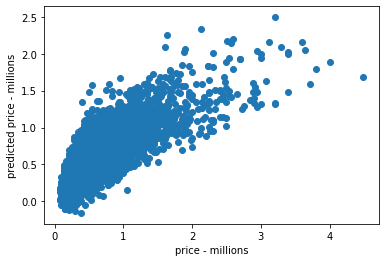

In [241]:
plt.scatter(y_train, predict_y_train)
plt.xlabel('price - millions')
plt.ylabel('predicted price - millions')
plt.show()

Text(0, 0.5, 'residuals')

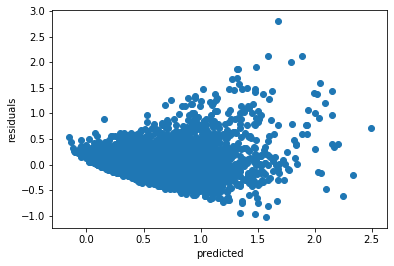

In [242]:
plt.scatter(predict_y_train, y_train - predict_y_train)
plt.xlabel('predicted')
plt.ylabel('residuals')

## Waterfront Segment Wins
- Out of all iterations, the waterfront segment had the highest linearity, highest homoscedasticity, and best p-values
- We can use sqft_living and grade in order to advise home owners who have waterfront properties, what kinds of improvements to their homes they should make

In [243]:
house_pred = df_water.drop(['price','price_millions'], axis=1)
house_target = df_water['price_millions']

In [244]:
predictors = sm.add_constant(house_pred)
model = sm.OLS(house_target, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price_millions   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     68.28
Date:                Sun, 08 Aug 2021   Prob (F-statistic):           4.74e-44
Time:                        20:49:42   Log-Likelihood:                -109.18
No. Observations:                 146   AIC:                             236.4
Df Residuals:                     137   BIC:                             263.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
bedrooms        0.0094      0.048      0.195      0.846      -0.086       0.105
bathrooms       0.0601      0.056      1.081      0.281      -0.050       0.170
sqft_living     0.4775      0.048      9.847      0.000       0.382       0.573
sqft_lot       -0.0506      0.041     -1.226      0.222      -0.132       0.031
floors         -0.0117      0.051     -0.229      0.819      -0.112       0.089
waterfront      0.0779      0.006     12.924      0.000       0.066       0.090
condition       0.0580      0.040      1.443      0.151      -0.021       0.137
grade           0.1040      0.054      1.915      0.058      -0.003       0.211
yr_built       -0.0737      0.064     -1.155      0.250      -0.200       0.052
==============================================================================
Omnibus:                        1.096   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.578   Jarque-Bera (JB):                0.878
Skew:                          -0.188   Prob(JB):                        0.645
Kurtosis:                       3.052   Cond. No.                         21.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [245]:
X = df_water.drop(['price','price_millions'], axis=1) # independent variables
y = df_water['price_millions'] # target variable

In [246]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=4)
lr = LinearRegression()
lr.fit(X_train, y_train)
predict_y_train = lr.predict(X_train)
print('The R squared value is: ' + str(metrics.r2_score(y_train, predict_y_train)))

The R squared value is: 0.8213563897907034


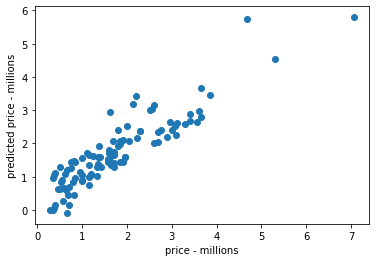

In [247]:
# Check linearity
plt.scatter(y_train, predict_y_train)
plt.xlabel('price - millions')
plt.ylabel('predicted price - millions')
plt.show()

Text(0, 0.5, 'residuals')

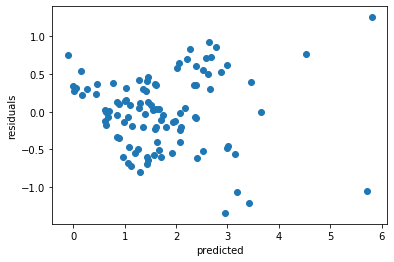

In [248]:
# Check level of homoscedasticity/heteroscedasticity
plt.scatter(predict_y_train, y_train - predict_y_train)
plt.xlabel('predicted')
plt.ylabel('residuals')

Text(0, 0.5, 'frequency')

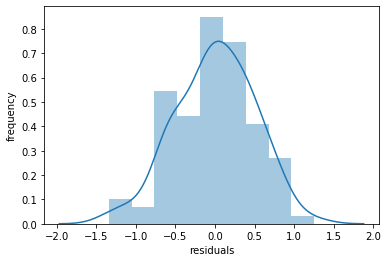

In [249]:
# Check Distribution of Errors:
sns.distplot(y_train - predict_y_train)
plt.xlabel('residuals')
plt.ylabel('frequency')

## Interpret Coefficient List:

In [250]:
# Create pandas data frame
waterfront_coef_list = pd.Series([0.0094, 0.0601, 0.4775, -0.0506, -0.0117, 0.0779, 0.058, 0.104, -0.0737], index=[
                                'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'yr_built'])

In [251]:
waterfront_coef_list

bedrooms       0.0094
bathrooms      0.0601
sqft_living    0.4775
sqft_lot      -0.0506
floors        -0.0117
waterfront     0.0779
condition      0.0580
grade          0.1040
yr_built      -0.0737
dtype: float64

In [252]:
# reverse transformation of z-score normalization:
trans_coef_list = (waterfront_coef_list + waterfront_coef_list.mean()) * waterfront_coef_list.std() 

In [253]:
# Remember these units are millions
trans_coef_list

bedrooms       0.013335
bathrooms      0.021608
sqft_living    0.089717
sqft_lot       0.003545
floors         0.009892
waterfront     0.024513
condition      0.021265
grade          0.028771
yr_built      -0.000225
dtype: float64

# Conclusion
- For every increase in grade, the house will sell for approximately $28,771 more.
- For every square-foot increase, the house will sell for approximately $89,717 more.
- Recommendations to home-owners in Kings County who have Waterfront properties:
    - Increase square-footage as much as possible
    - Make improvements that put home that give home a better grade according to King County's Grading System for Buildings such as:
        - Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.
        - Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.
        - Large amount of highest quality cabinet work, wood trim, marble, entry ways etc
